In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics as st
import keras
import glob
from imblearn.under_sampling import RandomUnderSampler
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from IPython import embed
from imblearn.over_sampling import SMOTE 
from sklearn.tree import plot_tree
from collections import Counter
import pickle
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

In [ ]:
train_path = '/content/drive/MyDrive/ECE542_sp2022_Project_TerrainRecognition/TrainingData/'
test_path = '/content/drive/MyDrive/ECE542_sp2022_Project_TerrainRecognition/TestData/'

In [ ]:
all_x_files = glob.glob(train_path + "/subject_00*_*__x.csv")
all_x_time_files = glob.glob(train_path + "/subject_00*_*__x_time.csv")
all_y_files = glob.glob(train_path + "/subject_00*_*__y.csv")
all_y_time_files = glob.glob(train_path + "/subject_00*_*__y_time.csv")

In [ ]:
subj1 = train_path + "/subject_001_01__x.csv"
subj1_time = train_path + "/subject_001_01__x_time.csv"

In [ ]:
df1 = pd.read_csv(subj1, sep = ',', names = ['X_acc', 'Y_acc', 'Z_acc', 'X_gyr', 'Y_gyr', 'Z_gyr'])

In [ ]:
df1.head()

,X_acc,Y_acc,Z_acc,X_gyr,Y_gyr,Z_gyr
0,4.435275,8.196063,2.974488,0.014215,-0.039157,-0.016744
1,4.186920,8.344455,2.908057,0.005771,-0.004480,-0.003345
2,4.544637,8.408659,2.890000,0.007967,0.022412,0.001159
3,4.849308,8.411614,2.900692,0.027778,-0.010670,-0.014223
4,4.509190,8.118649,2.847298,0.021577,-0.045498,-0.021111


In [ ]:
len(df1)

37890

In [ ]:
df2 = pd.read_csv(subj1_time, names = ['Time stamp'])

In [ ]:
df2.head()

,Time stamp
0,0.000
1,0.025
2,0.050
3,0.075
4,0.100


In [ ]:
df1_2 =pd.concat([df1,df2], axis = 1)

In [ ]:
df1_2.head()

,X_acc,Y_acc,Z_acc,X_gyr,Y_gyr,Z_gyr,Time stamp
0,4.435275,8.196063,2.974488,0.014215,-0.039157,-0.016744,0.000
1,4.186920,8.344455,2.908057,0.005771,-0.004480,-0.003345,0.025
2,4.544637,8.408659,2.890000,0.007967,0.022412,0.001159,0.050
3,4.849308,8.411614,2.900692,0.027778,-0.010670,-0.014223,0.075
4,4.509190,8.118649,2.847298,0.021577,-0.045498,-0.021111,0.100


In [ ]:
subj1_y = train_path + "/subject_001_01__y.csv"
subj1_y_time = train_path + "/subject_001_01__y_time.csv"

In [ ]:
df1_y = pd.read_csv(subj1_y, names = ['label'])
df1_y_time = pd.read_csv(subj1_y_time, names = ['Time stamp'])

In [ ]:
df1_y.head()

,label
0,0
1,0
2,0
3,0
4,0


In [ ]:
df1_y_time.head()

,Time stamp
0,0.02
1,0.12
2,0.22
3,0.32
4,0.42


In [ ]:
df1_2y =pd.concat([df1_y,df1_y_time], axis = 1)
df1_2y.head()

,label,Time stamp
0,0,0.02
1,0,0.12
2,0,0.22
3,0,0.32
4,0,0.42


In [ ]:
print(len(df1),len(df2),len(df1_2))
print(len(df1_y),len(df1_y_time),len(df1_2y))

37890 37890 37890
9473 9473 9473


In [ ]:
def get_subject_list(files):
  subject_list = []
  for filename in sorted(files):
    file=filename.split('/')[-1]
    subject_list.append(file)
  return subject_list

In [ ]:
subject_list_x = get_subject_list(all_x_files)
subject_list_x_time = get_subject_list(all_x_time_files)
subject_list_y = get_subject_list(all_y_files)
subject_list_y_time = get_subject_list(all_y_time_files)

In [ ]:
def combine_x_x_time(subj1,subj1_time):
  df1 = pd.read_csv(subj1, sep = ',', names = ['X_acc', 'Y_acc', 'Z_acc', 'X_gyr', 'Y_gyr', 'Z_gyr'])
  df2 = pd.read_csv(subj1_time, names = ['Time stamp'])
  df1_2 =pd.concat([df1,df2], axis = 1)
  return df1_2

In [ ]:
def combine_y_y_time(subj1_y,subj1_y_time):
  df1_y = pd.read_csv(subj1_y, names = ['label'])
  df1_y_time = pd.read_csv(subj1_y_time, names = ['Time stamp'])
  df1_2y =pd.concat([df1_y,df1_y_time], axis = 1)
  return df1_2y

In [ ]:
def combine_x_y(x_frame, y_frame):
    labels = y_frame['label'].tolist()
    time_stamp_y = y_frame['Time stamp'].tolist()
    print(len(time_stamp_y))
    time_stamp_x = x_frame['Time stamp'].tolist()
    print(len(time_stamp_x))
    
    labels_for_x = [] 
    count = 0
    for i in range(0, len(time_stamp_y)):
        while (time_stamp_x[count] <= time_stamp_y[i]) and (count <= len(time_stamp_x)):
            labels_for_x.append(labels[i])
            count += 1
        continue
    
    label_df = pd.DataFrame(labels_for_x, columns = ['label'])
    print(len(label_df))
    combined_frame = pd.concat([x_frame, label_df], axis = 1)
    
    combined_frame = combined_frame.dropna()
    
    combined_frame = combined_frame.drop(columns = ['Time stamp'])
    return combined_frame

In [ ]:
frame_list_x = []
for subj1,subj1_time in zip(subject_list_x,subject_list_x_time):
  print(subj1,subj1_time)
  df1_2 = combine_x_x_time(train_path + subj1,train_path + subj1_time)
  print(len(df1_2))
  frame_list_x.append(df1_2)


subject_001_01__x.csv subject_001_01__x_time.csv
37890
subject_001_02__x.csv subject_001_02__x_time.csv
70172
subject_001_03__x.csv subject_001_03__x_time.csv
43146
subject_001_04__x.csv subject_001_04__x_time.csv
54956
subject_001_05__x.csv subject_001_05__x_time.csv
59121
subject_001_06__x.csv subject_001_06__x_time.csv
38631
subject_001_07__x.csv subject_001_07__x_time.csv
31423
subject_001_08__x.csv subject_001_08__x_time.csv
66762
subject_002_01__x.csv subject_002_01__x_time.csv
55999
subject_002_02__x.csv subject_002_02__x_time.csv
55401
subject_002_03__x.csv subject_002_03__x_time.csv
48797
subject_002_04__x.csv subject_002_04__x_time.csv
51461
subject_002_05__x.csv subject_002_05__x_time.csv
42319
subject_003_01__x.csv subject_003_01__x_time.csv
36313
subject_003_02__x.csv subject_003_02__x_time.csv
47210
subject_003_03__x.csv subject_003_03__x_time.csv
19533
subject_004_01__x.csv subject_004_01__x_time.csv
34309
subject_004_02__x.csv subject_004_02__x_time.csv
34476
subject_00

In [ ]:
frame_list_y = []
for subj1,subj1_time in zip(subject_list_y,subject_list_y_time):
  print(subj1,subj1_time)
  df1_2y = combine_y_y_time(train_path +subj1,train_path +subj1_time)
  print(len(df1_2y))
  frame_list_y.append(df1_2y)  

subject_001_01__y.csv subject_001_01__y_time.csv
9473
subject_001_02__y.csv subject_001_02__y_time.csv
17543
subject_001_03__y.csv subject_001_03__y_time.csv
10787
subject_001_04__y.csv subject_001_04__y_time.csv
13739
subject_001_05__y.csv subject_001_05__y_time.csv
14780
subject_001_06__y.csv subject_001_06__y_time.csv
9658
subject_001_07__y.csv subject_001_07__y_time.csv
7856
subject_001_08__y.csv subject_001_08__y_time.csv
16691
subject_002_01__y.csv subject_002_01__y_time.csv
14000
subject_002_02__y.csv subject_002_02__y_time.csv
13850
subject_002_03__y.csv subject_002_03__y_time.csv
12199
subject_002_04__y.csv subject_002_04__y_time.csv
12865
subject_002_05__y.csv subject_002_05__y_time.csv
10580
subject_003_01__y.csv subject_003_01__y_time.csv
9078
subject_003_02__y.csv subject_003_02__y_time.csv
11803
subject_003_03__y.csv subject_003_03__y_time.csv
4883
subject_004_01__y.csv subject_004_01__y_time.csv
8577
subject_004_02__y.csv subject_004_02__y_time.csv
8619
subject_005_01__y

In [ ]:
combined_frame_list = []
for df_x, df_y in zip(frame_list_x, frame_list_y):
  combined_frame = combine_x_y(df_x, df_y)
  combined_frame_list.append(combined_frame)

9473
37890
37889
17543
70172
70169
10787
43146
43145
13739
54956
54953
14780
59121
59117
9658
38631
38629
7856
31423
31421
16691
66762
66761
14000
55999
55997
13850
55401
55397
12199
48797
48793
12865
51461
51457
10580
42319
42317
9078
36313
36309
11803
47210
47209
4883
19533
19529
8577
34309
34305
8619
34476
34473
14020
56079
56077
8630
34519
34517
11226
44905
44901
12031
48125
48121
14891
59562
59561
11282
45129
45125
11550
46201
46197
11747
46989
46985
11160
44641
44637
9860
39439
39437
12035
48138
48137


In [ ]:
df = pd.concat(combined_frame_list, axis = 0)

In [ ]:
len(df)

1341565

In [ ]:
walking = df[df.label==0].count()[0]
downstairs = df[df.label==1].count()[0]
upstairs = df[df.label==2].count()[0]
grass = df[df.label==3].count()[0]
print(walking, downstairs,upstairs, grass)

1006845 55216 73068 206436


In [ ]:
walking

1006845

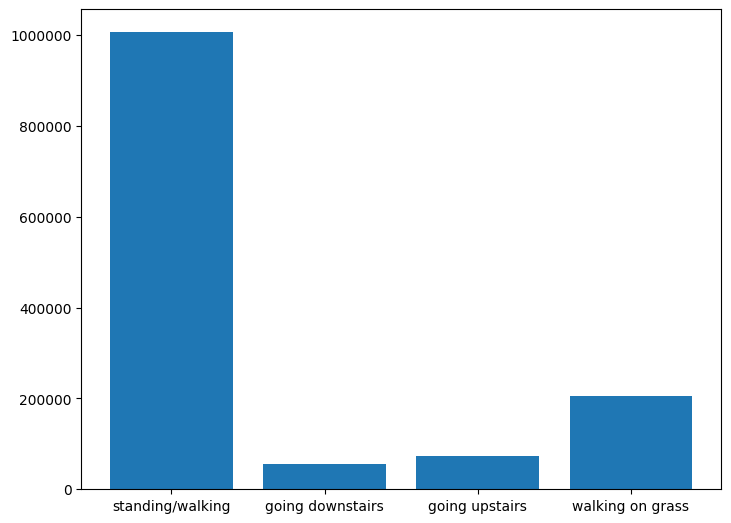

In [ ]:
text = ["standing/walking", "going downstairs","going upstairs", "walking on grass"]
label = [walking, downstairs,upstairs, grass]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.bar(text,label)
plt.show()

In [ ]:
x_train= df.drop('label', axis=1)
y_train = df.label

In [ ]:
output_path = '/content/drive/MyDrive/ECE542_sp2022_Project_TerrainRecognition/Output_files/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [ ]:
x_train.to_csv(output_path + 'x_train.csv')
y_train.to_csv(output_path + 'y_train.csv')

In [ ]:
county = Counter(y_train)
county

Counter({0.0: 1006845, 1.0: 55216, 2.0: 73068, 3.0: 206436})

In [ ]:
sm = SMOTE(random_state=23)
x_train_sm, y_train_sm = sm.fit_resample(x_train, y_train)
print(len(x_train_sm), len(y_train_sm))

county_sm = Counter(y_train_sm)
print(county_sm)

4027380 4027380
Counter({0.0: 1006845, 1.0: 1006845, 2.0: 1006845, 3.0: 1006845})


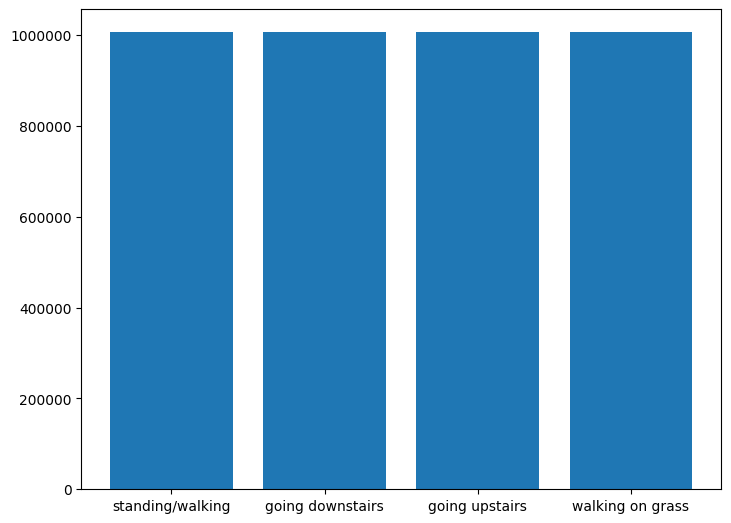

In [ ]:
text = ["standing/walking", "going downstairs","going upstairs", "walking on grass"]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.get_yaxis().get_major_formatter().set_scientific(False)
plt.bar(text, county_sm.values())
plt.show()

## Get training and testing set 

In [ ]:
x_train,x_val,y_train,y_val=train_test_split(x_train_sm, y_train_sm, test_size=0.2)

In [ ]:
print(len(x_train), len(y_train))
print(len(x_val), len(y_val))

3221904 3221904
805476 805476


In [ ]:
x_train.to_csv(output_path + 'x_train_sm.csv')
y_train.to_csv(output_path + 'y_train_sm.csv')
x_val.to_csv(output_path + 'x_val_sm.csv')
y_val.to_csv(output_path + 'y_val_sm.csv')

In [ ]:
x_train.head()

,X_acc,Y_acc,Z_acc,X_gyr,Y_gyr,Z_gyr
1561637,-1.399392,17.014197,10.575139,-1.683699,-1.600597,-0.446467
1530095,0.664469,1.617622,10.882510,-1.392880,-0.697540,-0.642910
3258815,-1.088364,-3.884695,-4.383529,-1.247108,-1.937497,-1.176444
1285142,7.814702,7.672287,4.813129,-0.295505,0.640524,0.621087
1793611,0.118456,8.013318,13.331275,-3.123799,0.393665,0.853958


## Random Forest

In [ ]:
Random_F_model = RandomForestClassifier(n_estimators=20, random_state=0)
Random_F_model.fit(x_train, y_train)

RandomForestClassifier(n_estimators=20, random_state=0)

In [ ]:
y_pred = Random_F_model.predict(x_val)

In [ ]:
target_names = ['class 0', 'class 1', 'class 2','class 3' ]
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.97      0.95      0.96    201410
     class 1       0.98      0.99      0.99    200867
     class 2       0.99      0.99      0.99    201573
     class 3       0.96      0.97      0.97    201626

    accuracy                           0.98    805476
   macro avg       0.98      0.98      0.98    805476
weighted avg       0.98      0.98      0.98    805476



In [ ]:
print('F1 Score:', metrics.f1_score(y_val, y_pred, average='macro'))
print('Accuracy Score:', metrics.accuracy_score(y_val, y_pred))
print('Precision score: ', metrics.precision_score(y_val, y_pred, average='macro'))
print('Recall score: ', metrics.recall_score(y_val, y_pred, average='macro'))
print('Accuracy Score:', metrics.accuracy_score(y_val, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_pred))

F1 Score: 0.9762188371968618
Accuracy Score: 0.9762748983209928
Precision score:  0.9762136669419451
Recall score:  0.9762848381830143
Accuracy Score: 0.9762748983209928
Mean Absolute Error: 0.056607521515228264


In [ ]:
print('Confusion Matrix:') 
print(metrics.confusion_matrix(y_val, y_pred))


Confusion Matrix:
[[191281   1989   1576   6564]
 [   790 199486    272    319]
 [   565    313 200463    232]
 [  4963    972    555 195136]]


In [ ]:
fn=['X_acc', 'Y_acc', 'Z_acc', 'X_gyr', 'Y_gyr', 'Z_gyr']


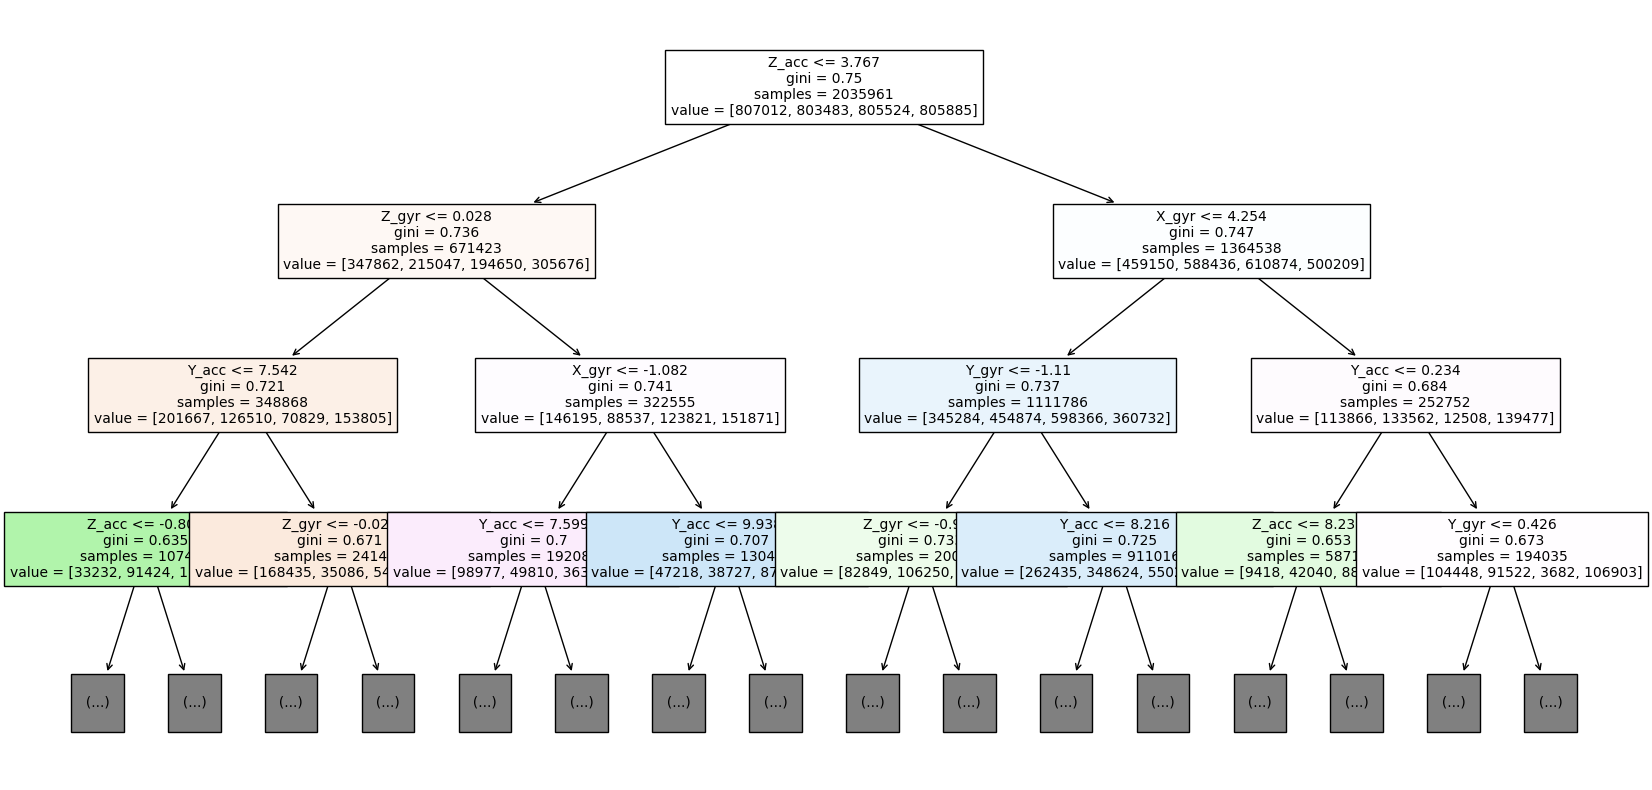

In [ ]:
plt.figure(figsize=(20, 10))
tree = Random_F_model.estimators_[0]
plot_tree(tree,feature_names = fn, max_depth=3,fontsize=10, filled = True)
plt.show()

# Getting the test set

In [ ]:
# Test_set 
x_test_files = glob.glob(test_path + "/subject_0*_*__x.csv")
x_test_time_files = glob.glob(test_path + "/subject_0*_*__x_time.csv")
y_test_time_files = glob.glob(test_path + "/subject_0*_*__y_time.csv")

In [ ]:
subject_list_x_test = get_subject_list(x_test_files)
subject_list_x_time_test = get_subject_list(x_test_time_files)
subject_list_y_time_test = get_subject_list(y_test_time_files)

In [ ]:
subject_list_x_test

['subject_009_01__x.csv',
 'subject_010_01__x.csv',
 'subject_011_01__x.csv',
 'subject_012_01__x.csv']

In [ ]:
frame_list_x_test = []
for subj1,subj1_time in zip(subject_list_x_test,subject_list_x_time_test):
  print(subj1,subj1_time)
  df1_2 = combine_x_x_time(test_path + subj1,test_path + subj1_time)
  print(len(df1_2))
  frame_list_x_test.append(df1_2)

subject_009_01__x.csv subject_009_01__x_time.csv
37991
subject_010_01__x.csv subject_010_01__x_time.csv
49081
subject_011_01__x.csv subject_011_01__x_time.csv
51761
subject_012_01__x.csv subject_012_01__x_time.csv
45319


In [ ]:
frame_list_y_test = []
for subj1_y in subject_list_y_time_test:
  df1_y_time = pd.read_csv(test_path + subj1_y, names = ['Time stamp'])
  frame_list_y_test.append(df1_y_time)


In [ ]:
def combine_x_y_test(x_frame, y_frame):

    time_stamp_y = y_frame['Time stamp'].tolist()
    print(len(time_stamp_y))
    time_stamp_x = x_frame['Time stamp'].tolist()
    print(len(time_stamp_x))
    x_frame_new = x_frame.copy().drop('Time stamp', axis=1)

    df_x = [] 
    count = 0
    for i in range(0, len(time_stamp_y)-1):
        while (time_stamp_x[count] <= time_stamp_y[i]) and (count <= len(time_stamp_x)):
            df_x_row = x_frame_new.iloc[count].tolist()
            df_x.append(df_x_row)
            count += 4
        continue
    df_x_last_row = x_frame_new.iloc[count+1].tolist()
    df_x.append(df_x_last_row)
    new_df_x = pd.DataFrame(df_x)
    return new_df_x

In [ ]:
test = []
for i in range(len(frame_list_y_test)):
  time_x = combine_x_y_test(frame_list_x_test[i], frame_list_y_test[i])
  test.append(time_x)


9498
37991
12270
49081
12940
51761
11330
45319


In [ ]:
subject9_X = pd.DataFrame(test[0])
subject9_X = pd.DataFrame(subject9_X.values, columns = ['X_acc', 'Y_acc', 'Z_acc', 'X_gyr', 'Y_gyr', 'Z_gyr'])
subject10_X = pd.DataFrame(test[1])
subject10_X = pd.DataFrame(subject10_X.values, columns = ['X_acc', 'Y_acc', 'Z_acc', 'X_gyr', 'Y_gyr', 'Z_gyr'])
subject11_X = pd.DataFrame(test[2])
subject11_X = pd.DataFrame(subject11_X.values, columns = ['X_acc', 'Y_acc', 'Z_acc', 'X_gyr', 'Y_gyr', 'Z_gyr'])
subject12_X = pd.DataFrame(test[3])
subject12_X = pd.DataFrame(subject12_X.values, columns = ['X_acc', 'Y_acc', 'Z_acc', 'X_gyr', 'Y_gyr', 'Z_gyr'])

In [ ]:
subject10_X

,X_acc,Y_acc,Z_acc,X_gyr,Y_gyr,Z_gyr
0,1.677089,9.653418,0.216836,-0.003305,-0.001139,-0.010541
1,1.643437,9.630000,0.226718,-0.000565,-0.003373,-0.006667
2,1.639583,9.632604,0.218698,-0.000996,-0.005147,-0.004151
3,1.629891,9.654946,0.204946,-0.002246,0.000409,-0.000725
4,1.524729,9.634946,0.255054,-0.000627,0.001111,0.001111
...,...,...,...,...,...,...
12265,1.029002,9.611286,1.151286,0.015047,0.043049,0.029042
12266,1.388496,9.596767,0.974737,0.067452,0.044085,0.022548
12267,1.077164,9.619083,0.662665,0.069404,-0.073914,-0.065202
12268,1.096480,9.604600,0.724320,0.030629,-0.030956,-0.039363


In [ ]:
subject9_X.head()

,X_acc,Y_acc,Z_acc,X_gyr,Y_gyr,Z_gyr
0,0.396845,8.710000,-4.476044,0.001111,-0.008889,0.004137
1,0.485234,8.725234,-4.520000,-0.000020,0.006667,0.007778
2,0.460536,8.709464,-4.480000,0.001815,0.004525,0.002981
3,0.463828,8.708437,-4.470000,-0.000466,0.005089,0.002867
4,0.454513,8.715487,-4.489026,0.002387,0.004444,0.002696


In [ ]:
len(subject9_X)

9498

In [ ]:
subject9_X.to_csv(output_path + 'subject9_X.csv')
subject10_X.to_csv(output_path + 'subject10_X.csv')
subject11_X.to_csv(output_path + 'subject11_X.csv')
subject12_X.to_csv(output_path + 'subject12_X.csv')

## Evaluating on test set

In [ ]:
y_pred_9 = Random_F_model.predict(subject9_X)
y_pred_10 = Random_F_model.predict(subject10_X)
y_pred_11 = Random_F_model.predict(subject11_X)
y_pred_12 = Random_F_model.predict(subject12_X)

In [ ]:
subject9 = pd.DataFrame(y_pred_9)
subject9.to_csv('subject_009_01__y.csv')
subject10 = pd.DataFrame(y_pred_10)
subject10.to_csv('subject_010_01__y.csv')
subject11 = pd.DataFrame(y_pred_11)
subject11.to_csv('subject_011_01__y.csv')
subject12 = pd.DataFrame(y_pred_12)
subject12.to_csv('subject_012_01__y.csv')